# Write your own native contacts analysis method

The `contacts.Contacts` class has been designed to be extensible for your own analysis. Here we demonstrate how to define a new method to use to determine the fraction of native contacts.

**Last updated:** December 2022 with MDAnalysis 2.4.0-dev0

**Minimum version of MDAnalysis:** 1.0.0

**Packages required:**
    
* MDAnalysis (<a data-cite="michaud-agrawal_mdanalysis_2011" href="https://doi.org/10.1002/jcc.21787">Michaud-Agrawal *et al.*, 2011</a>, <a data-cite="gowers_mdanalysis_2016" href="https://doi.org/10.25080/Majora-629e541a-00e">Gowers *et al.*, 2016</a>)
* MDAnalysisTests
* [matplotlib](https://matplotlib.org)
* [pandas](https://pandas.pydata.org)

**See also**

* [Fraction of native contacts over a trajectory](contacts_native_fraction.ipynb) (pre-defined metrics and a general introduction to native contacts analysis)
* [Q1 vs Q2 contact analysis](contacts_q1q2.ipynb)
* [Contact analysis: number of contacts within a cutoff](contacts_within_cutoff.ipynb)

In [1]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PSF, DCD
from MDAnalysis.analysis import contacts

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Loading files

The test files we will be working with here feature adenylate kinase (AdK), a phosophotransferase enzyme. (<a data-cite="beckstein_zipping_2009" href="https://doi.org/10.1016/j.jmb.2009.09.009">Beckstein *et al.*, 2009</a>) The trajectory ``DCD`` samples a transition from a closed to an open conformation.

In [2]:
u = mda.Universe(PSF, DCD)

/home/pbarletta/mambaforge/envs/mda-user-guide/lib/python3.9/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behaviour will be changed in 3.0 to be the same as other readers
  warnings.warn("DCDReader currently makes independent timesteps"


## Background

Please see the [Fraction of native contacts](contacts_native_fraction.ipynb#Background) for an introduction to general native contacts analysis.

## Defining salt bridges

We define salt bridges as contacts between NH/NZ in ARG/LYS and OE\*/OD\* in ASP/GLU. You may not want to use this definition for real work.

In [3]:
sel_basic = "(resname ARG LYS) and (name NH* NZ)"
sel_acidic = "(resname ASP GLU) and (name OE* OD*)"
acidic = u.select_atoms(sel_acidic)
basic = u.select_atoms(sel_basic)

## Define your own function

Any function you define *must* have `r` and `r0` as its first and second arguments respectively, even if you don't necessarily use them:

   - `r`: an array of distances between atoms at the current time
   - `r0`: an array of distances between atoms in the reference

You can then define following arguments as keyword arguments.

In the function below, we calculate the fraction of native contacts that are less than `radius`, but greater than `min_radius`.

In [4]:
def fraction_contacts_between(r, r0, radius=3.4, min_radius=2.5):
    is_in_contact = (r < radius) & (r > min_radius)  # array of bools
    fraction = is_in_contact.sum()/r.size
    return fraction

Then we pass `fraction_contacts_between` to the `contacts.Contacts` class. Keyword arguments for our custom function must be in the `kwargs` dictionary. Even though we define a `radius` keyword in my custom analysis function, it is *not* automatically passed from `contacts.Contacts`. We have to make sure that it is in `kwargs`. 

In [5]:
ca = contacts.Contacts(u, 
                       select=(sel_acidic, sel_basic),
                       refgroup=(acidic, basic),
                       method=fraction_contacts_between,
                       radius=5.0,
                       kwargs={'radius': 5.0,
                               'min_radius': 2.4}).run()

One easy way to post-process results is to turn them into a dataframe.

In [6]:
ca_df = pd.DataFrame(ca.results.timeseries, 
                    columns=['Frame', 
                             'Contacts from first frame'])
ca_df.head()

,Frame,Contacts from first frame
0,0.0,1.000000
1,1.0,0.988764
2,2.0,0.943820
3,3.0,0.943820
4,4.0,0.943820


### Plotting

We can plot directly from a dataframe (below), or you could use it with other plotting packags such as [seaborn](https://seaborn.pydata.org/).

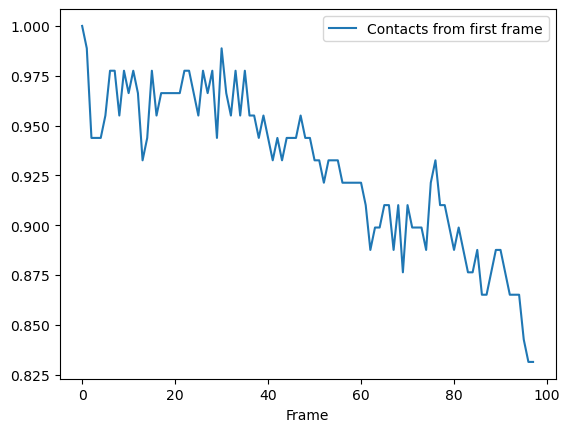

In [7]:
ca_df.plot(x='Frame');

## References

[1] Oliver Beckstein, Elizabeth&nbsp;J. Denning, Juan&nbsp;R. Perilla, and Thomas&nbsp;B. Woolf.
Zipping and <span class="bibtex-protected">Unzipping</span> of <span class="bibtex-protected">Adenylate</span> <span class="bibtex-protected">Kinase</span>: <span class="bibtex-protected">Atomistic</span> <span class="bibtex-protected">Insights</span> into the <span class="bibtex-protected">Ensemble</span> of <span class="bibtex-protected">Open</span>↔<span class="bibtex-protected">Closed</span> <span class="bibtex-protected">Transitions</span>.
<em>Journal of Molecular Biology</em>, 394(1):160–176, November 2009.
00107.
URL: <a href="https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164">https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164</a>, <a href="https://doi.org/10.1016/j.jmb.2009.09.009">doi:10.1016/j.jmb.2009.09.009</a>.

[2] Richard&nbsp;J. Gowers, Max Linke, Jonathan Barnoud, Tyler J.&nbsp;E. Reddy, Manuel&nbsp;N. Melo, Sean&nbsp;L. Seyler, Jan Domański, David&nbsp;L. Dotson, Sébastien Buchoux, Ian&nbsp;M. Kenney, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> <span class="bibtex-protected">Python</span> <span class="bibtex-protected">Package</span> for the <span class="bibtex-protected">Rapid</span> <span class="bibtex-protected">Analysis</span> of <span class="bibtex-protected">Molecular</span> <span class="bibtex-protected">Dynamics</span> <span class="bibtex-protected">Simulations</span>.
<em>Proceedings of the 15th Python in Science Conference</em>, pages 98–105, 2016.
00152.
URL: <a href="https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html">https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html</a>, <a href="https://doi.org/10.25080/Majora-629e541a-00e">doi:10.25080/Majora-629e541a-00e</a>.

[3] Naveen Michaud-Agrawal, Elizabeth&nbsp;J. Denning, Thomas&nbsp;B. Woolf, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> toolkit for the analysis of molecular dynamics simulations.
<em>Journal of Computational Chemistry</em>, 32(10):2319–2327, July 2011.
00778.
URL: <a href="http://doi.wiley.com/10.1002/jcc.21787">http://doi.wiley.com/10.1002/jcc.21787</a>, <a href="https://doi.org/10.1002/jcc.21787">doi:10.1002/jcc.21787</a>.